In [1]:
from tld import get_tld
import bz2
import json
import pandas as pd
import multiprocessing 


In [2]:
%load_ext autoreload
%autoreload 2

import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  

seed = 42
random.seed(seed)
np.random.seed(seed)

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [3]:
nlp = spacy.load('en')

In [4]:
fileroot = '/media/shanci/DataDisk/ada_quotebank/' 
json_list = []
for i in range(22):
    json = pd.read_json(fileroot + "chunk_{}.json".format(i))
    json_list.append(json)
    

In [33]:
total_json = pd.concat(json_list)
data = total_json.groupby('date')['quotation'].apply(lambda x:x.str.cat(sep=' ')).reset_index()
# data.to_json("/media/shanci/DataDisk/ada_quotebank/transformed_by_day.json")

In [34]:
data = data.iloc[:11]
data.head()

,date,quotation
0,2019-01-01,"actually embarrassed for the governor, Most le..."
1,2019-01-02,a major step in improving our footing in Latin...
2,2019-01-03,"always willing to help her coworkers, no matte..."
3,2019-01-04,A Pile of Leaves. All my customers aren't work...
4,2019-01-05,It's turning into this foodie community and th...


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       11 non-null     datetime64[ns]
 1   quotation  11 non-null     object        
 2   tokens     11 non-null     object        
dtypes: datetime64[ns](1), object(2)
memory usage: 392.0+ bytes


In [9]:
stop_words = []

f = open('stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['t', 'will']
stop_words += additional_stop_words

print(len(stop_words))

668


In [10]:
# They remove non ascii characters and standardize the text (can't -> cannot, i'm -> i am). This will make the tokenization process more efficient.
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [11]:
# Integrate these two functions into a tokenizing function.
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

In [15]:

# import packages
from __future__ import print_function
import requests
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter
import re

import pandas as pd
pd.options.display.max_columns = 200
pd.options.mode.chained_assignment = None

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from string import punctuation

from collections import Counter
import re
import numpy as np

from functools import reduce

from tqdm.notebook import tqdm
tqdm.pandas()

In [35]:
data['quotation'] = data['quotation'].map(lambda d: str(d))
data['tokens'] = data['quotation'].progress_map(lambda d: tokenizer(d))

  0%|          | 0/11 [00:00<?, ?it/s]

In [45]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/shanci/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [49]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
data['POS_tokens'] = data['tokens'].apply(lambda x: pos_tag(x))


In [50]:
data.head()

,date,quotation,tokens,POS_tokens
0,2019-01-01,"actually embarrassed for the governor, Most le...","[embarrassed, governor, lenders, treat, regula...","[(embarrassed, VBN), (governor, NN), (lenders,..."
1,2019-01-02,a major step in improving our footing in Latin...,"[major, step, improving, footing, latin, ameri...","[(major, JJ), (step, NN), (improving, VBG), (f..."
2,2019-01-03,"always willing to help her coworkers, no matte...","[help, coworkers, matter, busy, displays, prof...","[(help, NN), (coworkers, NNS), (matter, RBR), ..."
3,2019-01-04,A Pile of Leaves. All my customers aren't work...,"[pile, leaves, customers, working, people, ski...","[(pile, NN), (leaves, VBZ), (customers, NNS), ..."
4,2019-01-05,It's turning into this foodie community and th...,"[turning, foodie, community, wanted, fabric, g...","[(turning, VBG), (foodie, JJ), (community, NN)..."


In [52]:
a = data["POS_tokens"].iloc[0]

In [ ]:
data["tokens"].iloc[0]

In [56]:
from nltk.corpus import wordnet
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# sentence = 'football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.'
# tokens = word_tokenize(sentence)  # 分词
# tagged_sent = pos_tag(tokens)     # 获取单词词性

wnl = WordNetLemmatizer()
lemmas = []
for i in range(11):
    temp_lem = []
    for tag in data["POS_tokens"].iloc[i]:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        temp_lem.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) # 词形还原
    lemmas.append(temp_lem)
data['token_after_lem'] = lemmas


In [57]:
data.head()

,date,quotation,tokens,POS_tokens,token_after_lem
0,2019-01-01,"actually embarrassed for the governor, Most le...","[embarrassed, governor, lenders, treat, regula...","[(embarrassed, VBN), (governor, NN), (lenders,...","[embarrass, governor, lender, treat, regulatio..."
1,2019-01-02,a major step in improving our footing in Latin...,"[major, step, improving, footing, latin, ameri...","[(major, JJ), (step, NN), (improving, VBG), (f...","[major, step, improve, foot, latin, america, e..."
2,2019-01-03,"always willing to help her coworkers, no matte...","[help, coworkers, matter, busy, displays, prof...","[(help, NN), (coworkers, NNS), (matter, RBR), ...","[help, coworkers, matter, busy, display, profe..."
3,2019-01-04,A Pile of Leaves. All my customers aren't work...,"[pile, leaves, customers, working, people, ski...","[(pile, NN), (leaves, VBZ), (customers, NNS), ...","[pile, leave, customer, work, people, skill, c..."
4,2019-01-05,It's turning into this foodie community and th...,"[turning, foodie, community, wanted, fabric, g...","[(turning, VBG), (foodie, JJ), (community, NN)...","[turn, foodie, community, want, fabric, grow, ..."


In [ ]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

lemmatizer = WordNetLemmatizer()

# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

In [26]:
len(data['tokens'].values[0])

277913

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz = vectorizer.fit_transform(list(data['token_after_lem'].map(lambda tokens: ' '.join(tokens))))

print(vz.shape)

(11, 121621)


In [60]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

<AxesSubplot:>

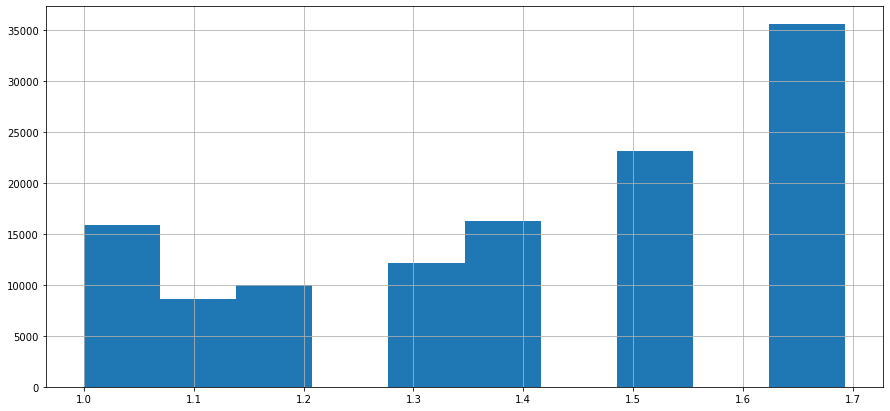

In [65]:
tfidf.tfidf.hist(bins=10, figsize=(15,7))

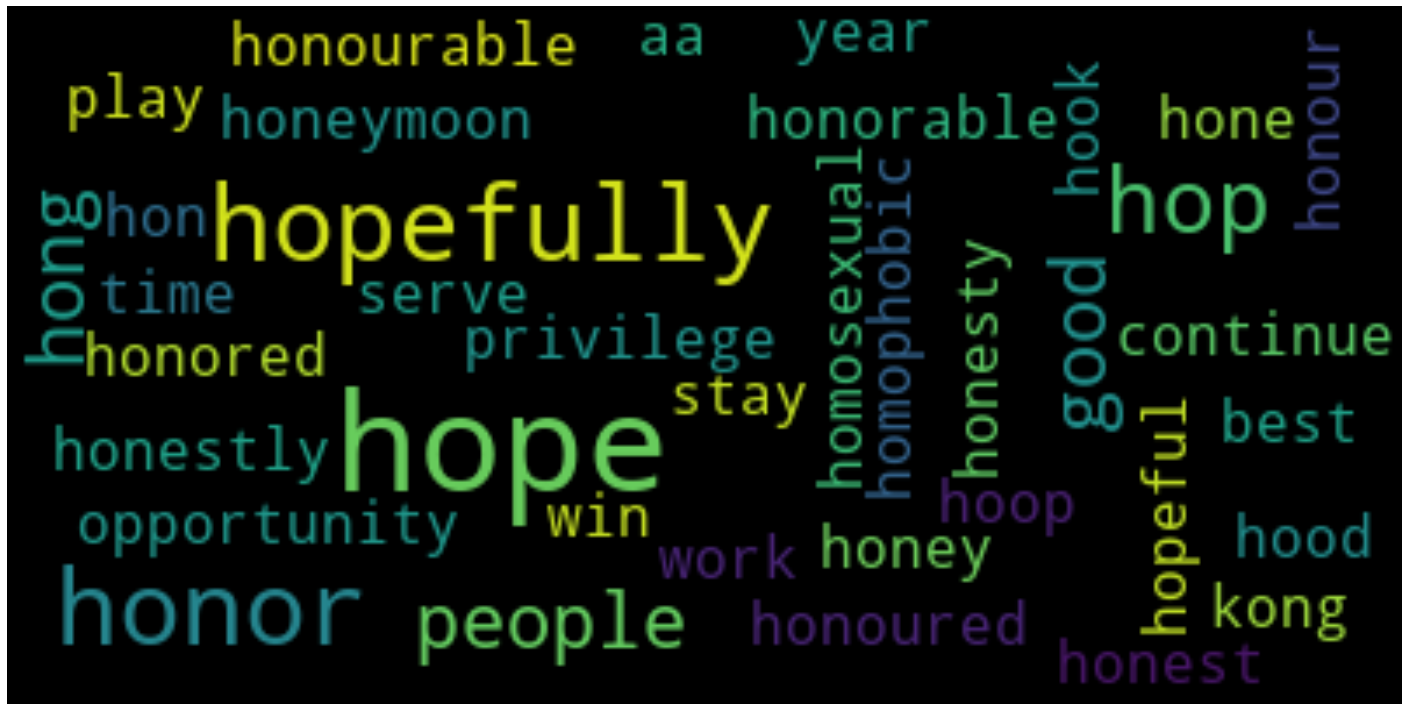

In [62]:
from wordcloud import WordCloud

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))

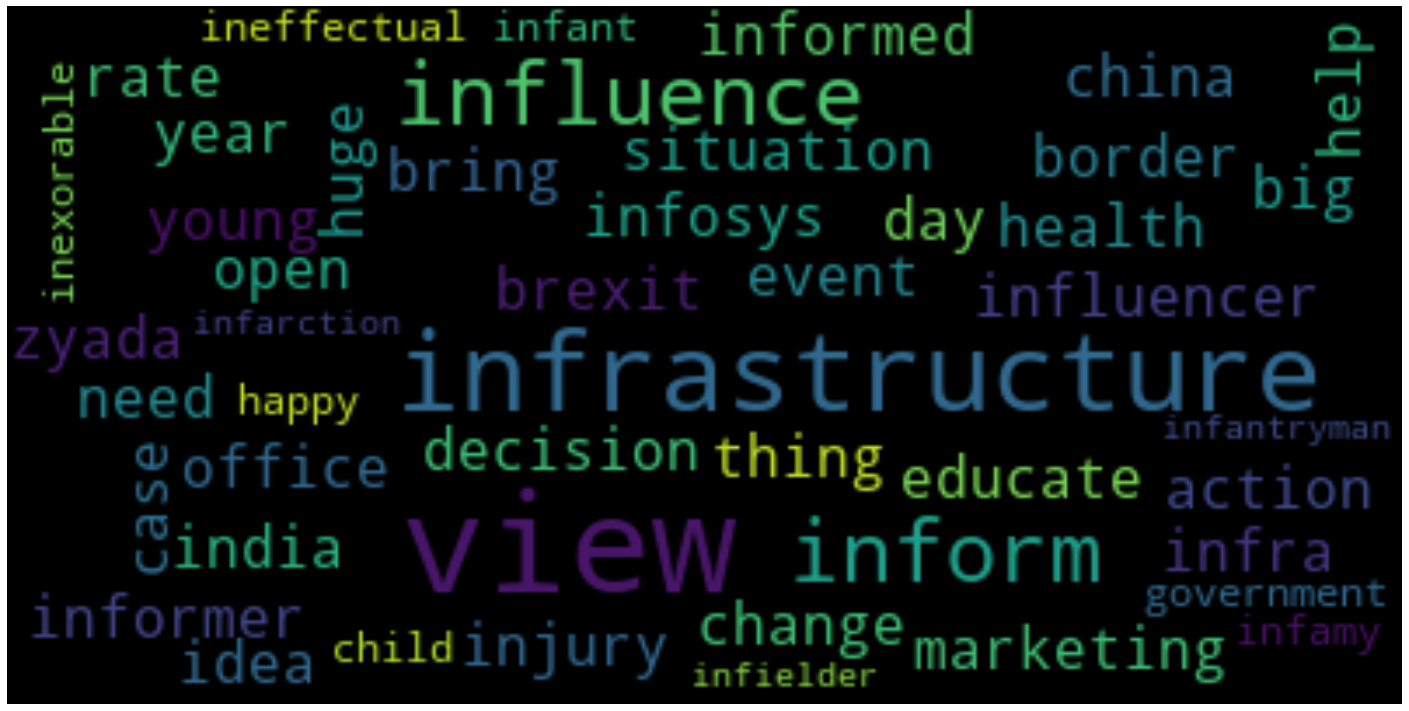

In [63]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

In [16]:
from nltk.tokenize import sent_tokenize
# from tqdm import tqdm_notebook
# tqdm_notebook().pandas()
from tqdm.notebook import tqdm
tqdm.pandas()
data['quotation'].iloc[:2].progress_map(sent_tokenize)
# data['sentences'] = data['quotation'].progress_map(sent_tokenize)
# data['sentences'].head(1).tolist()[0][:3]

  0%|          | 0/2 [00:00<?, ?it/s]

0    [actually embarrassed for the governor, Most l...
1    [a major step in improving our footing in Lati...
Name: quotation, dtype: object

In [81]:
string = data['quotation'].iloc[0]
len(string.split(' '))

760886

In [90]:
day1 = data['quotation'].iloc[0]
text_file = open("/media/shanci/DataDisk/ada_quotebank/day1.txt", 'w') 
text_file.write(day1)

4193741

In [91]:
# Let's load our corpus via NLTK this time
fileroot = '/media/shanci/DataDisk/ada_quotebank/' 
from nltk.corpus import PlaintextCorpusReader
our_books = PlaintextCorpusReader(fileroot, '.*.txt')
print(our_books.fileids())

['day1.txt']


In [92]:
for f in our_books.fileids():
    sentences = our_books.sents(f)
    print(f)
    print('Number of sentences:',len(sentences))
    break

day1.txt
Number of sentences: 34825


In [94]:

def get_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
# Get the chunks again (into smaller chunks)
book_id = {f:n for n,f in enumerate(our_books.fileids())} # dictionary of books
chunks = list()
chunk_class = list() # this list contains the original book of the chunk, for evaluation

limit = 60 # how many chunks total
size = 50 # how many sentences per chunk/page

for f in our_books.fileids():
    sentences = our_books.sents(f)
    print(f)
    print('Number of sentences:',len(sentences))
    
    # create chunks
    chunks_of_sents = [x for x in get_chunks(sentences,size)] # this is a list of lists of sentences, which are a list of tokens
    chs = list()
    
    # regroup so to have a list of chunks which are strings
    for c in chunks_of_sents:
        grouped_chunk = list()
        for s in c:
            grouped_chunk.extend(s)
        chs.append(" ".join(grouped_chunk))
    print("Number of chunks:",len(chs),'\n')
    
    # filter to the limit, to have the same number of chunks per book
    chunks.extend(chs[:limit])
    chunk_class.extend([book_id[f] for _ in range(len(chs[:limit]))])

day1.txt
Number of sentences: 34825
Number of chunks: 697 



In [98]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

processed_docs = list()
for doc in nlp.pipe(chunks, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

In [99]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [100]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 918
Number of chunks: 60


In [119]:
# models
from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [120]:
model.show_topics(num_words=5)

[(0,
  '0.006*"public" + 0.005*"bad" + 0.005*"decision" + 0.005*"close" + 0.004*"write"'),
 (1,
  '0.006*"Year" + 0.006*"New_Year" + 0.006*"talk" + 0.006*"season" + 0.005*"farmer"'),
 (2,
  '0.006*"issue" + 0.005*"party" + 0.005*"bit" + 0.005*"talk" + 0.005*"old"'),
 (3,
  '0.007*"lose" + 0.006*"ball" + 0.005*"bad" + 0.005*"hear" + 0.005*"turn"')]

In [124]:
len(corpus)

60

In [126]:
model[corpus]

In [121]:
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

/home/shanci/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/shanci/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/shanci/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/shanci/anaconda3/envs/ada/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/shanci/anaconda3/envs/ada/lib/python3.8/site-packa

In [22]:
filename = '/media/shanci/DataDisk/ada_quotebank/chunk_0.json' 

df_reader = pd.read_json(filename)
df_reader.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       365 non-null    datetime64[ns]
 1   quotation  365 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 8.6+ KB


In [ ]:
string = df_reader['quotation'].iloc[0]
string.split(' ')